In [1]:
%run mnist_poison_util.py

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


# Directory Layout
All clean and poisoned models are in "poisoned_datasets/models/(clean or poisoned)" directories. For now, I don't think you would need to work with "poisoned_datasets/models/(train or test)" which harbors poisoned samples for each attack group. So far there are 144 attack groups for trainig with different goals such as location, size, value, target labels, etc. For training attack scenario. For each single scenario I have generated 10 random dataset that targetted different clean images in the dataset so it has 1440 different attack dataset in 144 groups.
At each folder there is a gtable* file which contains metadata for each poisoned dataset or poisoned models which is a pandas dataframe.

In [2]:
import pandas as pd
from myutil import read_bz2_ret_pickle
tr_table = read_bz2_ret_pickle("./poisoned_datasets/train/gtable.pickle.bz2")
tst_table = read_bz2_ret_pickle("./poisoned_datasets/test/gtable.pickle.bz2")
tr_table['location'] = tr_table['location'].apply(tuple)
tr_table['attack_labels'] = tr_table['attack_labels'].apply(tuple)
tst_table['location'] = tst_table['location'].apply(tuple)
tst_table['attack_labels'] = tst_table['attack_labels'].apply(tuple)
tr_grouped = tr_table.groupby(by=['location','color','attack_labels','attack_ratio'])
print ('Total Attacking Scenario supported is: {}'.format(tr_grouped.ngroups))
tr_table.sample(n=3)

Total Attacking Scenario supported is: 144


,location,color,attack_ratio,attack_labels,p_seed,is_train,file_loc
848,"((10, 1),)",0.20,0.01,"((1, 5),)",949262.0,1.0,./poisoned_datasets/train/pois_848.pickle.bz2
399,"((2, 20),)",0.05,0.01,"((1, 5),)",881383.0,1.0,./poisoned_datasets/train/pois_399.pickle.bz2
417,"((2, 20),)",0.05,0.01,"((6, 9),)",945294.0,1.0,./poisoned_datasets/train/pois_417.pickle.bz2


In [3]:
tr_grouped_loc = tr_table.groupby(by=['location'])
print ('Total Attacking Scenario supported for location: {}'
       .format(tr_grouped_loc.ngroups))
tr_grouped_loc.count()

Total Attacking Scenario supported for location: 4


,color,attack_ratio,attack_labels,p_seed,is_train,file_loc
location,,,,,,
"((2, 2), (2, 3), (3, 2), (3, 3))",360,360,360,360,360,360
"((2, 20),)",360,360,360,360,360,360
"((10, 1),)",360,360,360,360,360,360
"((26, 26), (26, 27), (27, 26), (27, 27))",360,360,360,360,360,360


In [5]:
tr_grouped_atk_r = tr_table.groupby(by=['attack_ratio'])
print ('Total Attacking Scenario supported for attack ratio: {}'
       .format(tr_grouped_atk_r.ngroups))
tr_grouped_atk_r.count()

Total Attacking Scenario supported for attack ratio: 3


,location,color,attack_labels,p_seed,is_train,file_loc
attack_ratio,,,,,,
0.0015,480,480,480,480,480,480
0.0100,480,480,480,480,480,480
0.1000,480,480,480,480,480,480


In [4]:
tr_grouped_atk_lbl = tr_table.groupby(by=['attack_labels'])
print ('Total Attacking Scenario supported for attack labels: {}'
       .format(tr_grouped_atk_lbl.ngroups))
print ('(x,y) means labels are changed from x in clean to y in poisoned')
tr_grouped_atk_lbl.count()

Total Attacking Scenario supported for attack labels: 3
(x,y) means labels are changed from x in clean to y in poisoned


,location,color,attack_ratio,p_seed,is_train,file_loc
attack_labels,,,,,,
"((0, 8),)",480,480,480,480,480,480
"((1, 5),)",480,480,480,480,480,480
"((6, 9),)",480,480,480,480,480,480


In [15]:
tr_grouped_atk_color = tr_table.groupby(by=['color'])
print ('Total Attacking Scenario supported for color: {}'
       .format(tr_grouped_atk_color.ngroups))
tr_grouped_atk_color.count()

Total Attacking Scenario supported for color: 4


,location,attack_ratio,attack_labels,p_seed,is_train,file_loc
color,,,,,,
0.05,360,360,360,360,360,360
0.20,360,360,360,360,360,360
0.50,360,360,360,360,360,360
0.95,360,360,360,360,360,360


Populating the interactive namespace from numpy and matplotlib


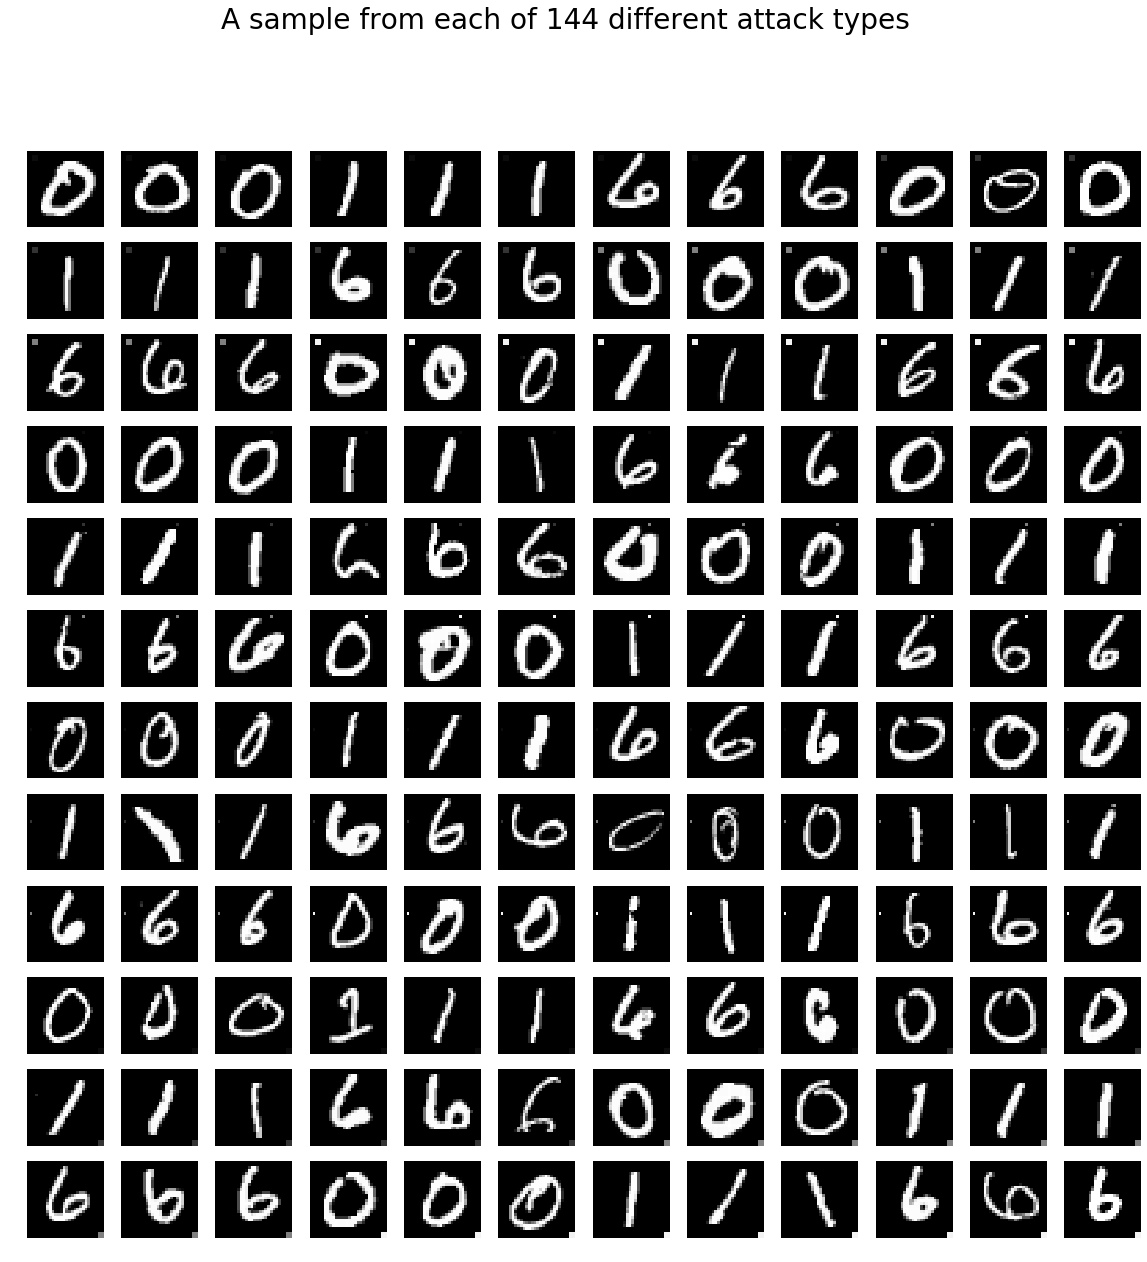

In [4]:
import matplotlib.pyplot as plt
import mnist_poison_util as mnp

def plot_initialize(w=16,h=12):
  %pylab inline
  plt.rcParams['figure.figsize'] = [w,h]
plot_initialize(w=20,h=20)
plt.suptitle("A sample from each of 144 different attack types", fontsize=28)
tr_table_grp = tr_table.groupby(by=['location','color','attack_labels','attack_ratio'])
samples_pois = [data.sample(n=1) for _,data in tr_table_grp]
samples_pois = pd.concat(samples_pois).reset_index(drop=True)
for i,row in samples_pois.iterrows():
  # load train and test set
  train_f = read_bz2_ret_pickle(row.file_loc)
  plt.subplot(12,12,i+1)
  plt.imshow(train_f['p_X'][0,...].reshape((28,28)),cmap='gray')
  plt.axis('off')    

# Poisoned Weights Storage and accessing locations based on layer
Poisoned weights are flattened and they are all in one dimension. Therefore, first you need to gather them in their corresponding layer group in the network architecture

In [5]:
pois_table = read_bz2_ret_pickle('./poisoned_datasets/models/poisoned/gtable-run.pickle.bz2')
poisoned_ds = read_bz2_ret_pickle('./poisoned_datasets/train/gtable.pickle.bz2')
pois_table.head()

,is_clean,log_strategy,rarng_seed,evl_loc,tr_loc,model_loc,evl_acc,attk_succ_rate
0,0.0,last,367646.0,./poisoned_datasets/test/pois_7.pickle.bz2,./poisoned_datasets/train/pois_0.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_0...,"[0.9811, 0.9874, 0.9869, 0.9886, 0.9913, 0.986...","[0.0, 0.0, 0.9612335, 0.9603524, 0.9876652, 0...."
1,0.0,last,321682.0,./poisoned_datasets/test/pois_7.pickle.bz2,./poisoned_datasets/train/pois_0.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_1...,"[0.9815, 0.9878, 0.9873, 0.989, 0.9886, 0.9913...","[0.004405286, 0.0052863434, 0.0052863434, 0.00..."
2,0.0,last,702924.0,./poisoned_datasets/test/pois_7.pickle.bz2,./poisoned_datasets/train/pois_0.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_2...,"[0.9802, 0.989, 0.9902, 0.9881, 0.9865, 0.9883...","[0.0008810573, 0.0, 0.0, 0.98061675, 0.9903083..."
3,0.0,last,835513.0,./poisoned_datasets/test/pois_9.pickle.bz2,./poisoned_datasets/train/pois_1.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_3...,"[0.982, 0.9818, 0.9803, 0.9812, 0.9884, 0.9898...","[0.007929515, 0.0052863434, 0.007929515, 0.346..."
4,0.0,last,309243.0,./poisoned_datasets/test/pois_9.pickle.bz2,./poisoned_datasets/train/pois_1.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_4...,"[0.9823, 0.9902, 0.9899, 0.9904, 0.9918, 0.992...","[0.0070484583, 0.011453745, 0.9788546, 0.98237..."


Let's just pick the location of the first model from the table that has location information from model_loc column. In case you need to select specific models you must join them with poisoned training dataset table (tr_loc), select rows based on criterias, then load corresponding models.

In [6]:
pois_table.iloc[0]['model_loc']
print ('the model is trained on the dataset {}'.format(pois_table.iloc[0]['tr_loc']))
temp_model = read_bz2_ret_pickle(pois_table.iloc[0]['model_loc'])
poisoned_ds[poisoned_ds.file_loc == pois_table.iloc[0]['tr_loc']]
temp_model

the model is trained on the dataset ./poisoned_datasets/train/pois_0.pickle.bz2


array([ 0.10259587, -0.27887213,  0.07540616, ...,  0.24283247,
        0.1392407 , -0.07655925])

Now temp_model is just an example of our models which is a flattend array of size (356234). You should know which indices correspond to which layers to conduct your analysis. For now let's ignore bias variables (starting with B) from our analysis since there are not so many of them, and stick to W's. For this current network I have a sample that keeps track of location of indices for each array named layer_bound

In [7]:
main_graph = tf.Graph()
net = NetSimple(device='/gpu:0',scope = '',n_classes = 10,main_graph=main_graph)
net.create_output_tensors()
net.print_scope_vars_range()

InvalidArgumentError: Cannot assign a device for operation W0/Initializer/random_uniform/RandomUniform: Could not satisfy explicit device specification '' because the node node W0/Initializer/random_uniform/RandomUniform (defined at C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\contrib\layers\python\layers\initializers.py:145) having device Device assignments active during op 'W0/Initializer/random_uniform/RandomUniform' creation:
  with tf.device(None): <C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py:1435>
  with tf.device(/gpu:0): <C:\Users\bduis_000\Documents\Python Scripts\ClusteringWeights\mnist_poison_util.py:287>  was colocated with a group of nodes that required incompatible device '/device:GPU:0'
Colocation Debug Info:
Colocation group had the following types and devices: 
Assign: CPU 
Add: CPU 
Const: CPU 
RandomUniform: CPU 
Sub: CPU 
VariableV2: CPU 
Mul: CPU 
Identity: CPU 
ApplyAdam: CPU 

Colocation members and user-requested devices:
  W0/Initializer/random_uniform/shape (Const) 
  W0/Initializer/random_uniform/min (Const) 
  W0/Initializer/random_uniform/max (Const) 
  W0/Initializer/random_uniform/RandomUniform (RandomUniform) 
  W0/Initializer/random_uniform/sub (Sub) 
  W0/Initializer/random_uniform/mul (Mul) 
  W0/Initializer/random_uniform (Add) 
  W0 (VariableV2) /device:GPU:0
  W0/Assign (Assign) /device:GPU:0
  W0/read (Identity) /device:GPU:0
  W0/Adam/Initializer/zeros (Const) /device:GPU:0
  W0/Adam (VariableV2) /device:GPU:0
  W0/Adam/Assign (Assign) /device:GPU:0
  W0/Adam/read (Identity) /device:GPU:0
  W0/Adam_1/Initializer/zeros (Const) /device:GPU:0
  W0/Adam_1 (VariableV2) /device:GPU:0
  W0/Adam_1/Assign (Assign) /device:GPU:0
  W0/Adam_1/read (Identity) /device:GPU:0
  Adam/update_W0/ApplyAdam (ApplyAdam) /device:GPU:0

	 [[node W0/Initializer/random_uniform/RandomUniform (defined at C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\contrib\layers\python\layers\initializers.py:145)  = RandomUniform[T=DT_INT32, _class=["loc:@W0"], dtype=DT_FLOAT, seed=0, seed2=0](W0/Initializer/random_uniform/shape)]]

No node-device colocations were active during op 'W0/Initializer/random_uniform/RandomUniform' creation.
Device assignments active during op 'W0/Initializer/random_uniform/RandomUniform' creation:
  with tf.device(None): <C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py:1435>
  with tf.device(/gpu:0): <C:\Users\bduis_000\Documents\Python Scripts\ClusteringWeights\mnist_poison_util.py:287>

Caused by op 'W0/Initializer/random_uniform/RandomUniform', defined at:
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-e4d43b8641a7>", line 3, in <module>
    net.create_output_tensors()
  File "C:\Users\bduis_000\Documents\Python Scripts\ClusteringWeights\mnist_poison_util.py", line 293, in create_output_tensors
    'wc1': tf.get_variable('W0', shape=(3, 3, 1, 32), initializer=tf.contrib.layers.xavier_initializer()),
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 540, in get_variable
    aggregation=aggregation)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 1329, in __init__
    constraint=constraint)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 1437, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 896, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\contrib\layers\python\layers\initializers.py", line 145, in _initializer
    dtype, seed=seed)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\random_ops.py", line 243, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 732, in random_uniform
    name=name)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation W0/Initializer/random_uniform/RandomUniform: Could not satisfy explicit device specification '' because the node node W0/Initializer/random_uniform/RandomUniform (defined at C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\contrib\layers\python\layers\initializers.py:145) having device Device assignments active during op 'W0/Initializer/random_uniform/RandomUniform' creation:
  with tf.device(None): <C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py:1435>
  with tf.device(/gpu:0): <C:\Users\bduis_000\Documents\Python Scripts\ClusteringWeights\mnist_poison_util.py:287>  was colocated with a group of nodes that required incompatible device '/device:GPU:0'
Colocation Debug Info:
Colocation group had the following types and devices: 
Assign: CPU 
Add: CPU 
Const: CPU 
RandomUniform: CPU 
Sub: CPU 
VariableV2: CPU 
Mul: CPU 
Identity: CPU 
ApplyAdam: CPU 

Colocation members and user-requested devices:
  W0/Initializer/random_uniform/shape (Const) 
  W0/Initializer/random_uniform/min (Const) 
  W0/Initializer/random_uniform/max (Const) 
  W0/Initializer/random_uniform/RandomUniform (RandomUniform) 
  W0/Initializer/random_uniform/sub (Sub) 
  W0/Initializer/random_uniform/mul (Mul) 
  W0/Initializer/random_uniform (Add) 
  W0 (VariableV2) /device:GPU:0
  W0/Assign (Assign) /device:GPU:0
  W0/read (Identity) /device:GPU:0
  W0/Adam/Initializer/zeros (Const) /device:GPU:0
  W0/Adam (VariableV2) /device:GPU:0
  W0/Adam/Assign (Assign) /device:GPU:0
  W0/Adam/read (Identity) /device:GPU:0
  W0/Adam_1/Initializer/zeros (Const) /device:GPU:0
  W0/Adam_1 (VariableV2) /device:GPU:0
  W0/Adam_1/Assign (Assign) /device:GPU:0
  W0/Adam_1/read (Identity) /device:GPU:0
  Adam/update_W0/ApplyAdam (ApplyAdam) /device:GPU:0

	 [[node W0/Initializer/random_uniform/RandomUniform (defined at C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\contrib\layers\python\layers\initializers.py:145)  = RandomUniform[T=DT_INT32, _class=["loc:@W0"], dtype=DT_FLOAT, seed=0, seed2=0](W0/Initializer/random_uniform/shape)]]

No node-device colocations were active during op 'W0/Initializer/random_uniform/RandomUniform' creation.
Device assignments active during op 'W0/Initializer/random_uniform/RandomUniform' creation:
  with tf.device(None): <C:\Users\bduis_000\Anaconda3\envs\BalnurEnv\lib\site-packages\tensorflow\python\ops\variables.py:1435>
  with tf.device(/gpu:0): <C:\Users\bduis_000\Documents\Python Scripts\ClusteringWeights\mnist_poison_util.py:287>


In [8]:
# These ranges are inclusive
layers_bound = {'conv1':[('W0:0',0,287),],
                'conv2':[('W1:0',288,18719),],
                'conv3':[('W2:0',18720,92447),],
                'fc1':[('W3:0',92448,354591),],
                'fc2':[('W6:0',354592,355871),],}

# Graph Clustering
We would like to conduct two graph clustering algorithm. One is Markov Clustering Algorithm, the other one is spectral clustering. Whichever is assigned to you, please carefully read the documentation on their parameters
1. https://github.com/GuyAllard/markov_clustering
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

You can start with small random samples from both clean and poisoned models (50%,50%). For these graph clustering algorithms to work, we would consider each model as a node, and there will be an edge between any two nodes that has the similarity score (different similarities that should be tested and defined below) between these models

### Clustering for layer conv1 using ks_2samp

In [10]:
import markov_clustering as mc
import networkx as nx
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ks_2samp
import random


clean_table = read_bz2_ret_pickle('./poisoned_datasets/models/clean/gtable-run.pickle.bz2').sample(n=500)
pois_table2 = read_bz2_ret_pickle('./poisoned_datasets/models/poisoned-selected/gtable-run.pickle.bz2').sample(n=500)  


In [11]:
p_size = 500
c_size = 500

pois_models = [read_bz2_ret_pickle(pois_table2.iloc[i]['model_loc'])[0:288] for i in range(p_size)]
clean_models = [read_bz2_ret_pickle(clean_table.iloc[i]['model_loc'])[0:288] for i in range(c_size)] 

#### poisoned models are 0-499, and clean ones are 500-999

In [12]:
G=nx.Graph()

for i in range(p_size):
    for j in range(c_size):
        d,pval = ks_2samp(pois_models[i],clean_models[j])        
        G.add_edge(i, j+p_size, weight=pval ) 

In [16]:
matrix=nx.to_scipy_sparse_matrix(G)
clusters=mc.get_clusters(mc.run_mcl(matrix,inflation=1.4))
len(clusters)

2

In [20]:
clusters
# below line draws graph, but that looks messy with 1000 nodes
# mc.draw_graph(matrix, clusters, edge_color="silver")

[(0,
  501,
  502,
  503,
  504,
  505,
  506,
  507,
  508,
  509,
  510,
  511,
  512,
  513,
  514,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  527,
  528,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  538,
  539,
  540,
  541,
  542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  555,
  556,
  557,
  558,
  559,
  560,
  561,
  562,
  563,
  564,
  565,
  566,
  567,
  568,
  569,
  570,
  571,
  572,
  573,
  574,
  575,
  576,
  577,
  578,
  579,
  580,
  581,
  582,
  583,
  584,
  585,
  586,
  587,
  588,
  589,
  590,
  591,
  592,
  593,
  594,
  595,
  596,
  597,
  598,
  599,
  600,
  601,
  602,
  603,
  604,
  605,
  606,
  607,
  608,
  609,
  610,
  611,
  612,
  613,
  614,
  615,
  616,
  617,
  618,
  619,
  620,
  621,
  622,
  623,
  624,
  625,
  626,
  627,
  628,
  629,
  630,
  631,
  632,
  633,
  634,
  635,
  636,
  637,
  638,
  639,
  640,
  641,
  642,
 

### Clustering for layer conv2 using ks_2samp

In [21]:
pois_models2 = [read_bz2_ret_pickle(pois_table2.iloc[i]['model_loc'])[288:18720] for i in range(p_size)]
clean_models2 = [read_bz2_ret_pickle(clean_table.iloc[i]['model_loc'])[288:18720] for i in range(c_size)]  

In [22]:
# Sample code for rank eliminate
def rank_eliminate(w,remove_odd = False,thresh_size=None):
  if thresh_size is None:
    raise Exception('Threshold size should be given')
  if not isinstance(w, list):
    w = w.reshape((1,-1))
  w = np.sort(w)
  start_ind = 1 if remove_odd else 0
  while w.shape[1] > thresh_size:
    rem_ind = np.arange(start_ind,w.shape[1],2,dtype=int)
    if w.shape[1] - len(rem_ind) < thresh_size:
      rem_ind = rem_ind[:w.shape[1]-thresh_size]
    w = np.delete(w,rem_ind,axis=1)
  return w.reshape((-1,))

In [23]:
# it might give better results without rank elimination like in the first layer
rank_eliminate(pois_models2, True, 500)
rank_eliminate(clean_models2, True, 500)

array([-0.96025801, -0.60793263, -0.54178977, ...,  0.31724268,
        0.34019497,  0.37246916])

In [24]:
G=nx.Graph()

p_size = len(pois_models2)
c_size = len(clean_models2)

for i in range(p_size):
    for j in range(c_size):
        d,pval = ks_2samp(pois_models2[i],clean_models2[j])
        G.add_edge(i, j+p_size, weight=pval ) 

In [33]:
matrix=nx.to_scipy_sparse_matrix(G)
clusters=mc.get_clusters(mc.run_mcl(matrix,inflation=1.01))
G.nodes()
len(clusters)

10

In [34]:
clusters
# mc.draw_graph(matrix, clusters, edge_color="silver")

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  15

### Clustering of conv2 with cosine similarity function below

In [35]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def calculate_angle(a,b,sorted=True):
  if sorted:
    a = np.sort(a)
    b = np.sort(b)
  v1_u = unit_vector(a)
  v2_u = unit_vector(b)
  return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [36]:
G=nx.Graph()

p_size = len(pois_models2)
c_size = len(clean_models2)

for i in range(p_size):
    for j in range(c_size):
        a = calculate_angle(pois_models2[i],clean_models2[j])
        G.add_edge(i, j+p_size, weight=a )

In [37]:
matrix=nx.to_scipy_sparse_matrix(G)
clusters=mc.get_clusters(mc.run_mcl(matrix,inflation=1.5))
G.nodes()
len(clusters)

2

In [38]:
clusters
# mc.draw_graph(matrix, clusters, edge_color="silver")

[(0,
  501,
  502,
  503,
  504,
  505,
  506,
  507,
  508,
  509,
  510,
  511,
  512,
  513,
  514,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  527,
  528,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  538,
  539,
  540,
  541,
  542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  555,
  556,
  557,
  558,
  559,
  560,
  561,
  562,
  563,
  564,
  565,
  566,
  567,
  568,
  569,
  570,
  571,
  572,
  573,
  574,
  575,
  576,
  577,
  578,
  579,
  580,
  581,
  582,
  583,
  584,
  585,
  586,
  587,
  588,
  589,
  590,
  591,
  592,
  593,
  594,
  595,
  596,
  597,
  598,
  599,
  600,
  601,
  602,
  603,
  604,
  605,
  606,
  607,
  608,
  609,
  610,
  611,
  612,
  613,
  614,
  615,
  616,
  617,
  618,
  619,
  620,
  621,
  622,
  623,
  624,
  625,
  626,
  627,
  628,
  629,
  630,
  631,
  632,
  633,
  634,
  635,
  636,
  637,
  638,
  639,
  640,
  641,
  642,
 

### Clustering of conv3 with cosine similarity

In [39]:
pois_models3 = [read_bz2_ret_pickle(pois_table2.iloc[i]['model_loc'])[18720:92448] for i in range(p_size)]
clean_models3 = [read_bz2_ret_pickle(clean_table.iloc[i]['model_loc'])[18720:92448] for i in range(c_size)]  

In [40]:
rank_eliminate(pois_models3, True, 500)
rank_eliminate(clean_models3, True, 500)

array([-0.92131925, -0.54567832, -0.48959246, ...,  0.274342  ,
        0.29386196,  0.3232533 ])

In [42]:
G=nx.Graph()

p_size = len(pois_models3)
c_size = len(clean_models3)

for i in range(p_size):
    for j in range(c_size):
        a = calculate_angle(pois_models3[i],clean_models3[j])
        G.add_edge(i, j+p_size, weight=a )

In [43]:
matrix=nx.to_scipy_sparse_matrix(G)
clusters=mc.get_clusters(mc.run_mcl(matrix,inflation=1.5))
G.nodes()
len(clusters)

2

In [44]:
clusters
# mc.draw_graph(matrix, clusters, edge_color="silver")

[(0,
  501,
  502,
  503,
  504,
  505,
  506,
  507,
  508,
  509,
  510,
  511,
  512,
  513,
  514,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  527,
  528,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  538,
  539,
  540,
  541,
  542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  555,
  556,
  557,
  558,
  559,
  560,
  561,
  562,
  563,
  564,
  565,
  566,
  567,
  568,
  569,
  570,
  571,
  572,
  573,
  574,
  575,
  576,
  577,
  578,
  579,
  580,
  581,
  582,
  583,
  584,
  585,
  586,
  587,
  588,
  589,
  590,
  591,
  592,
  593,
  594,
  595,
  596,
  597,
  598,
  599,
  600,
  601,
  602,
  603,
  604,
  605,
  606,
  607,
  608,
  609,
  610,
  611,
  612,
  613,
  614,
  615,
  616,
  617,
  618,
  619,
  620,
  621,
  622,
  623,
  624,
  625,
  626,
  627,
  628,
  629,
  630,
  631,
  632,
  633,
  634,
  635,
  636,
  637,
  638,
  639,
  640,
  641,
  642,
 

## Similarity Measures
1. Cos similarity (The closer this value is to zero the more similar two samples are) (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity)
2. Test statistics value of Kolmogrov Smirnov two sample test (The lower the closer two samples are) (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html)

## Test for different layers
According to our initial analysis the most important layers are conv2, conv3,and fc1, but I want you to test similarities between models on all layers separately.

## Selecting a sample of weights
For layers that are larger than our threshold (500,1000,5000),let's sample according to following algorithm:
1. Sort values
2. Recursively, remove even records until you have the necessary amount of samples
Again, here we would like to have tests for all this sample selection size. Please keep this new order of sorted values before feeding it to similarity measure function
## Some possible optimization
1. When creating this fully connected graph of similarities between any two models in experiment (poisoned and clean) you can only keep some percentage of top similarities. You can test for values such as 100%, 50%,20%,10%, and 5%.
## Goal
We would like to know if we can separate the clean runs and poisoned runs into separate clusters, or at least most of them. The best scenario would be to see if we can have one cluster for most clean runs and another one for the rest. But, it is possible that we may need more clusters, then as long as we can separate out most if the cleans, that should be good too.

In [13]:
# Sample code for rank eliminate
def rank_eliminate(w,remove_odd = False,thresh_size=None):
  if thresh_size is None:
    raise Exception('Threshold size should be given')
  w = w.reshape((1,-1))
  w = np.sort(w)
  start_ind = 1 if remove_odd else 0
  while w.shape[1] > thresh_size:
    rem_ind = np.arange(start_ind,w.shape[1],2,dtype=int)
    if w.shape[1] - len(rem_ind) < thresh_size:
      rem_ind = rem_ind[:w.shape[1]-thresh_size]
    w = np.delete(w,rem_ind,axis=1)
  return w.reshape((-1,))

